# Metalens Optimization with FourierFields

This tutorial illustates the adjoint solver for DFT fields. Specifically, we use the `FourierFields` adjoint solver to design a metalens that maximizes the average intensity over three frequencies at a spot near the metalens. In a similar [example](https://github.com/NanoComp/meep/blob/master/python/examples/adjoint_optimization/05-Near2Far.ipynb) based on the `Near2FarFields` adjoint solver, the focal spot is far from the metalens. Compared with `Near2FarFields`, the `FourierFields` adjoint solver has some advantages, including higher efficiency for fields at nearby points and greater flexibility for surrounding media (not limited to homogeneous media surrounding far-field regions when `Near2FarFields` is applied). On the other hand, the disadvantage is that `FourierFields` is less efficient for faraway points, which require a large computational cell.

At first, let us import `meep`, its adjoint module `meep.adjoint`, and other packages for automatic differentiation, nonlinear optimization, and making figures.

In [77]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

mp.verbosity(1)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1.0)

Basic setup

In [78]:
resolution = 25

design_region_width = 3.0
design_region_height = 1.0
pml_size = 1.0

Sx = 2 * pml_size + design_region_width
Sy = 2 * pml_size + design_region_height + 5
cell_size = mp.Vector3(Sx, Sy)

wavelength = 1.55
fcen = 1/wavelength
# nf = len(frequencies) # number of frequencies

minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
design_region_resolution = int(resolution)

pml_layers = [mp.PML(thickness = pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [0, -(Sy / 2) + pml_size + 2/resolution, 0]
source_size = mp.Vector3(Sx, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, size=source_size, center=source_center)]

Nx = int(round(design_region_resolution * design_region_width)) + 1
Ny = int(round(design_region_resolution * design_region_height)) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, 1), Air, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0,-Sy/2 + pml_size + 1.5),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # projection
    # projected_field = mpa.tanh_projection(x, beta, eta)

    # interpolate to actual materials
    return x


geometry = [
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    )
]

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=Air,
    resolution=resolution,
    k_point = mp.Vector3(0,0,0)
)

To use the `mpa.FourierFields` adjoint solver, we need to specify the monitor where DFT fields are evaluated. In this example, we try to focus the light at three different frequencies. The objective function is simply the intensity at the focal spot averaged over those frequencies.

     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)


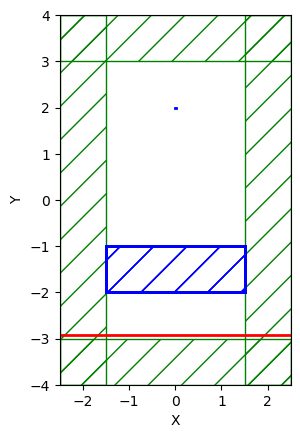

In [79]:
monitor_position, monitor_size = mp.Vector3(0,-Sy/2 + pml_size + 1.5 + design_region_height/2 + 3), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,1]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
    # maximum_run_time=150,
    decay_by=1e-7,
    finite_difference_step=0.001 
)
opt.plot2D(True)

To apply `nlopt` for nonlinear optimization, the following function is defined. This function also illustrates the structure in the design region during optimization and records the evaluation history of the objective function.

In [80]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

The optimizer runs in multiple loops with increasing beta, which gradually turns on the thresholding. When beta changes, the cost function also changes, which requires the optimizer to be reset.

In [81]:
f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 0.000136137 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0209329 s
-----------
run 0 finished at t = 81.14 (4057 timesteps)
Starting adjoint run...
run 1 finished at t = 161.36 (8068 timesteps)
Calculating gradient...


In [82]:
print(dJ_du)
print(f0)

[-1.84744887 -1.57181461 -1.30930848 -1.04723672 -0.78696441 -0.52974162
 -0.27670168 -0.02886046  0.21288288  0.44774334  0.67504748  0.8942284
  1.10482139  1.30645754  1.49885779  1.68182592  1.85524145  2.01905251
  2.17326803  2.31795085  2.45320974  2.57919282  2.6960799   2.80407639
  2.90340624  2.99430637  3.0770205   3.15179415  3.21886946  3.27848083
  3.3308507   3.37618599  3.41467475  3.44648338  3.47175421  3.49060348
  3.50311979  3.50936283  3.50936266  3.50311929  3.49060267  3.47175308
  3.44648196  3.41467306  3.37618406  3.33084856  3.2784785   3.21886699
  3.15179157  3.07701784  2.99430368  2.90340356  2.80407375  2.69607736
  2.5791904   2.45320749  2.31794879  2.1732662   2.01905093  1.85524015
  1.68182492  1.4988571   1.30645716  1.10482133  0.89422866  0.67504805
  0.44774421  0.21288403 -0.02885905 -0.27670003 -0.52973978 -0.78696239
 -1.04723458 -1.30930624 -1.57181232 -1.84744655]
3.7767039552958597


In [83]:
print(dJ_du.size)

76


In [84]:
#x = np.loadtxt('/root/design_result/gd/lastdesign.txt')

n = Nx * 1  # number of parameters
x = np.ones((n,)) * 0.5
opt.update_design([x])

fdg_list=[]
eps_diff=0.001

f0, dJ_du = opt([x])
for i in range(x.size):
    print(i)
    copy_x=x.copy()
    copy_x[i] = copy_x[i]+eps_diff
    #print(copy_x)
    f0_new, dJ_du_new = opt([copy_x])
    f0_diff = f0_new - f0
    fdg = f0_diff / eps_diff
    #fdg_list.append(np.real(fdg))
    fdg_list.append(fdg)

# np.savetxt("/root/design_result/gd/fdg_list.txt", fdg_list)

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0220459 s
-----------
run 2 finished at t = 477.38 (23869 timesteps)
Starting adjoint run...
run 3 finished at t = 370.40000000000003 (18520 timesteps)
Calculating gradient...
0
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 8.79765e-05 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.022083 s
-----------
run 4 finished at t = 438.38 (21919 timesteps)
Starting adjoint run...
run 5 finished at t = 370.40000000000003 (18520 timesteps)
Calculating gradient...
1
Starting forward run...
---------

In [85]:
print(fdg_list)

[0.37427688926827685, 0.4550435692749488, 0.4487845422875836, 0.3525942122597492, 0.2004311050671781, 0.046526760077103546, -0.06271666633761441, -0.09705750062005691, -0.07726931816121052, -0.049595117006973055, -0.06777883570885379, -0.1762175560515722, -0.37410014330419017, -0.6228680381603624, -0.8580552539920738, -1.0155825092272863, -1.0581434674419299, -0.9898056254229459, -0.854995779626222, -0.7075032858891994, -0.5998135494387213, -0.5508820664248404, -0.5398907853142454, -0.528402980776832, -0.46753723800296854, -0.33292603917267627, -0.13527874115082383, 0.08344166726814706, 0.26884949160921323, 0.37875333566406155, 0.39912341582581945, 0.35905270469971384, 0.3022682105524588, 0.2746243428384254, 0.30604212731155656, 0.3812865476553462, 0.46945575396506456, 0.5278898738616533, 0.5278902075107617, 0.4694565692822117, 0.3812873681638962, 0.3060423949658997, 0.2746236733317531, 0.3022665952387982, 0.35905057502194637, 0.39912154670052047, 0.378752619561773, 0.26885066589743545

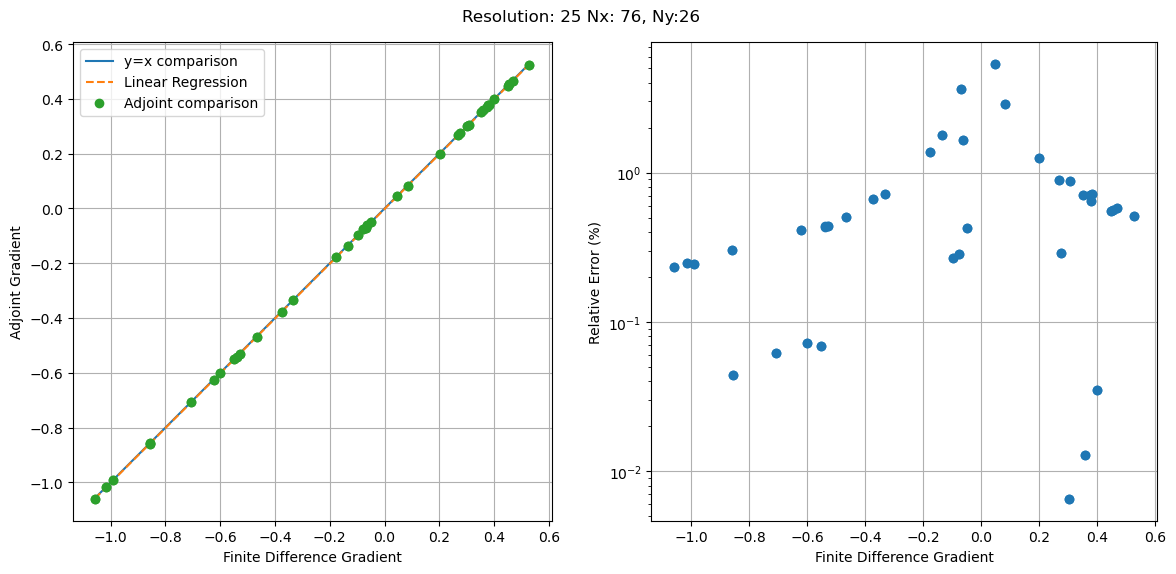

In [86]:
fd_gradient=np.array(fdg_list)
#print(x)
opt.update_design([x])
#(f, dJ_du)=opt.get_fdf_funcs()
#adjoint_gradient=dJ_du(x)
adjoint_gradient=dJ_du

(m, b) = np.polyfit(fd_gradient, adjoint_gradient, 1)
min_g = np.min(fd_gradient)
max_g = np.max(fd_gradient)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Linear Regression")
plt.plot(fd_gradient, adjoint_gradient, "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(fd_gradient) - np.squeeze(adjoint_gradient))
    / np.abs(np.squeeze(fd_gradient))
    * 100
)
plt.semilogy(fd_gradient, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Nx: {}, Ny:{}".format(resolution, Nx, Ny))
plt.show()

We can plot the optimized geometry.

In [87]:
db = 1e-5
choose = 76
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.02229 s
-----------
run 156 finished at t = 465.44 (23272 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.5129e-05 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.0222352 s
-----------
run 157 finished at t = 465.44 (23272 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.20296e-05 s
Working in 2D dimensions.
Computational cell is 5 x 8 x 0 with resolution 25
     block, center = (0,-1.5,0)
          size (3,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.024241 s
------

In [88]:
print(g_discrete)

[[0.37167018900330356], [0.4520213860326194], [0.44570764479168185], [0.3495035033607152], [0.19743915478098725], [0.04375825666258492], [-0.061744012547215725], [-0.09672262983873024], [-0.07693285477561318], [-0.04929327506175695], [-0.07016618963628929], [-0.17853237206377767], [-0.3762854292377326], [-0.6247995197217193], [-0.8595940065303508], [-1.0167053390297554], [-1.0589901690671866], [-0.9905854600145146], [-0.8531498318919971], [-0.7058379821289761], [-0.5983728585512438], [-0.5496250788272761], [-0.5413890774352836], [-0.5298568904743561], [-0.4689948103209218], [-0.334533266288517], [-0.13716014710674074], [0.0812365444025076], [0.26630375598024614], [0.3758636229145295], [0.39868303429724244], [0.35853027970933476], [0.30182509311860173], [0.2750659332306782], [0.30303056737235323], [0.37819713749609457], [0.4662400535870858], [0.5245658590835589], [0.5245105510143233], [0.46610421036152866], [0.3780536795394695], [0.3029544223931424], [0.2750934410267192], [0.30193268871

In [89]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

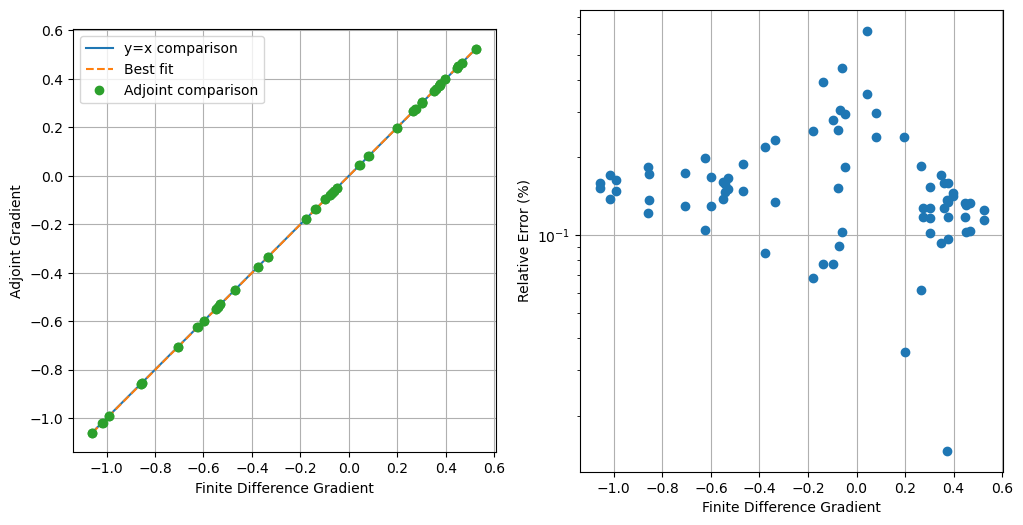

In [90]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()

Text(0, 0.5, 'Error')

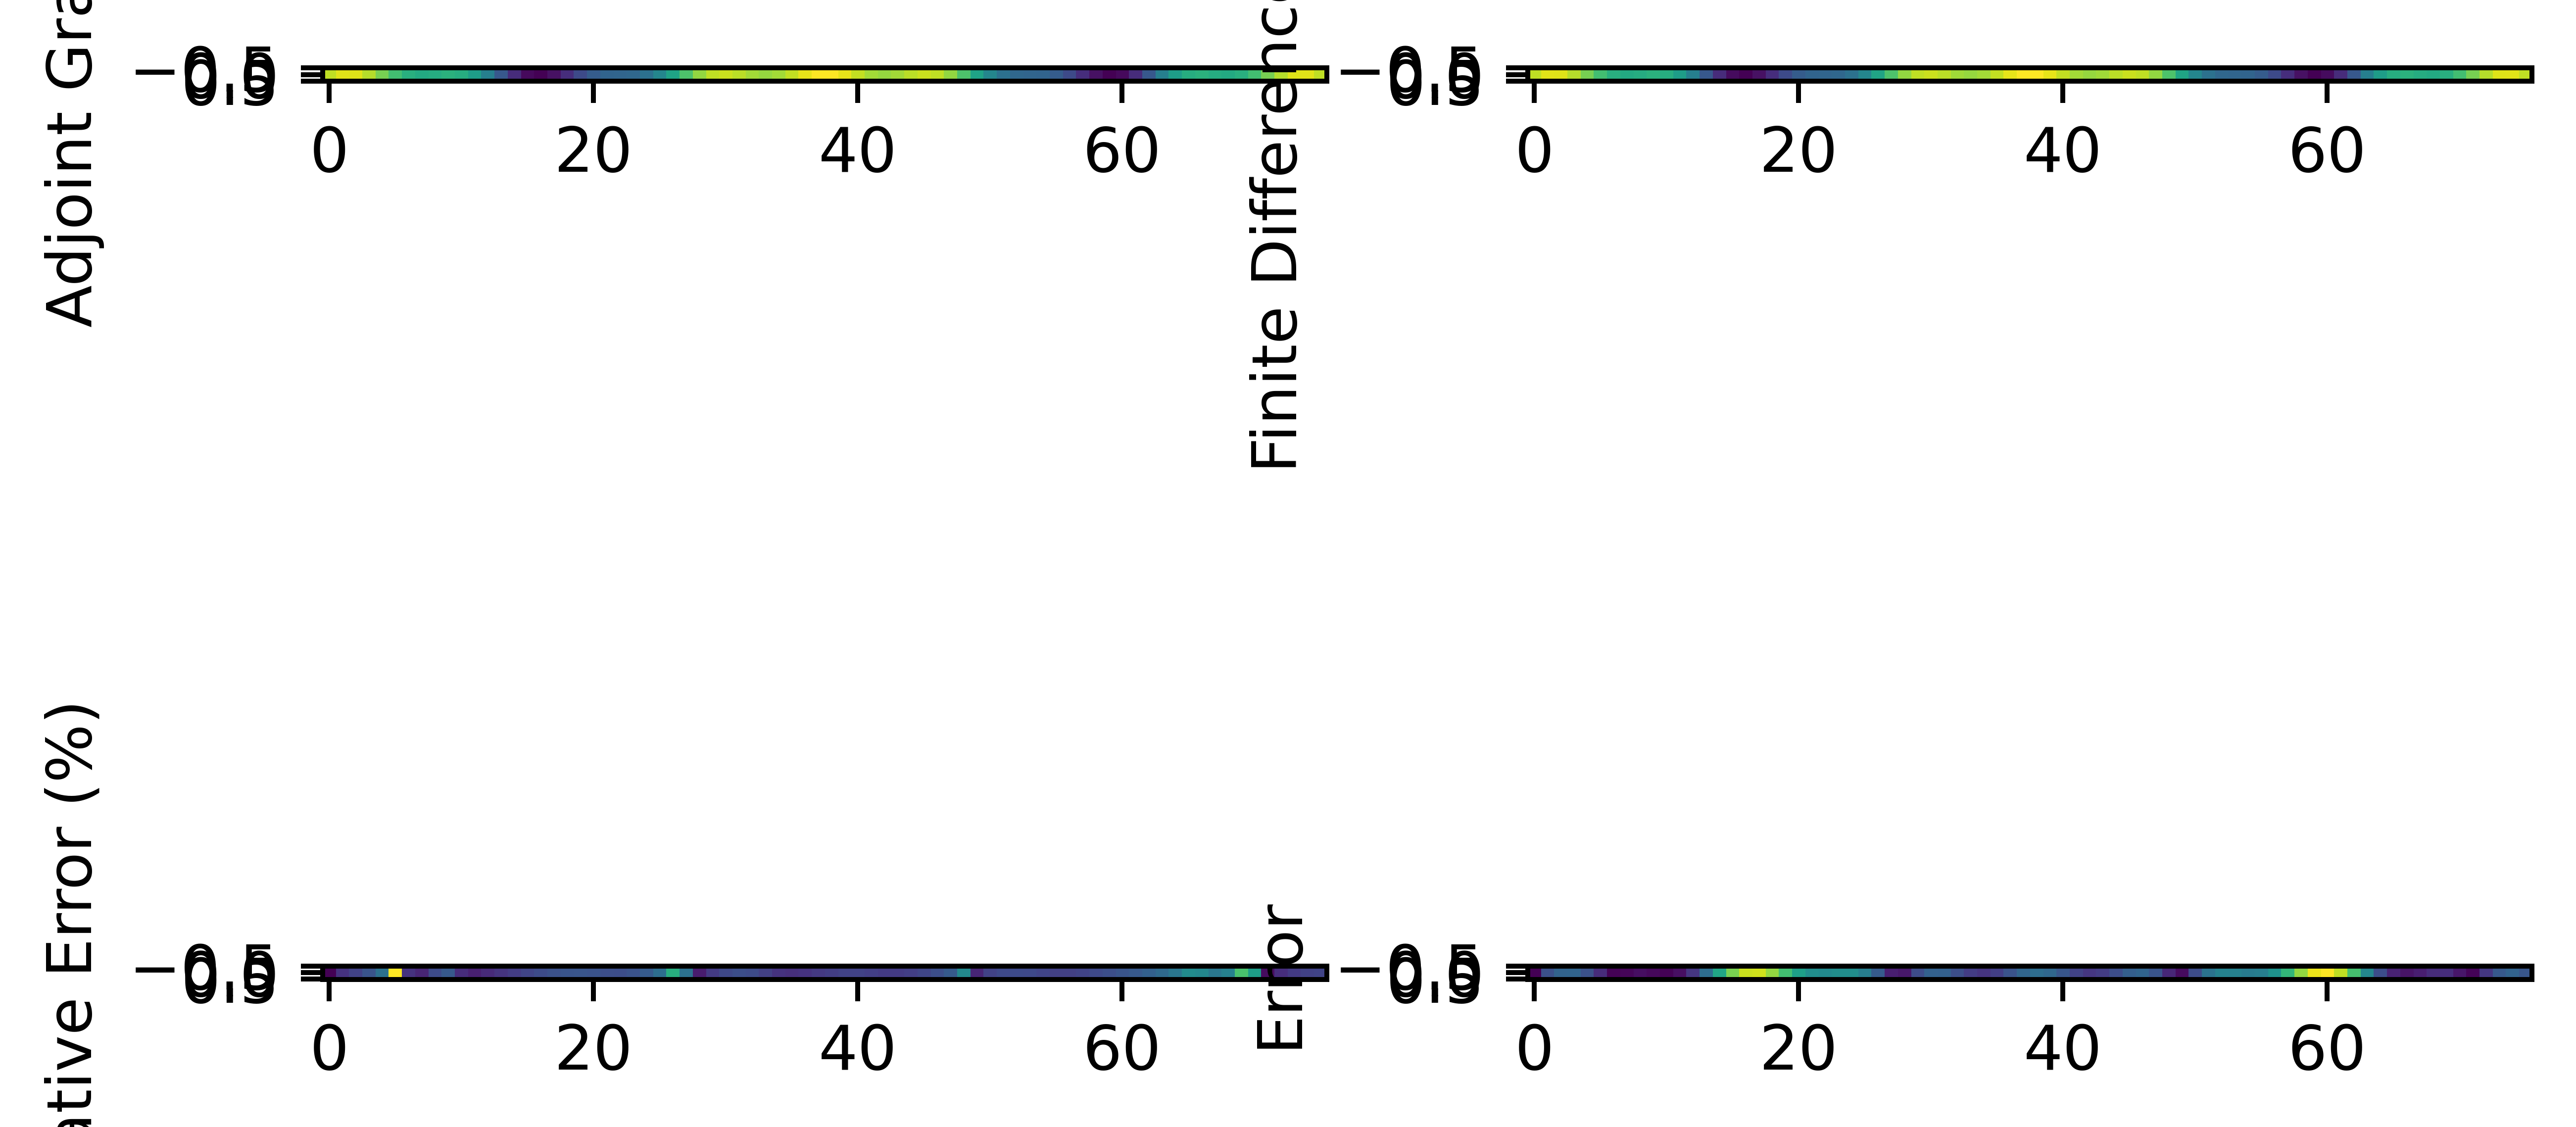

In [91]:
plt.figure(dpi=900)
plt.subplot(2, 2, 1)
dJ_du_0 = dJ_du.reshape(Nx, 1)
plt.imshow(np.rot90(dJ_du_0.reshape(Nx, 1)),)
plt.ylabel("Adjoint Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))
# plt.colorbar()


plt.subplot(2, 2, 2)
g_discrete_0 = np.squeeze(g_discrete).reshape(Nx, 1)
plt.imshow(np.rot90(g_discrete_0.reshape(Nx, 1)),)
plt.ylabel("Finite Difference Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))
# plt.colorbar()



plt.subplot(2, 2, 3)
err_p=rel_err.reshape(Nx, 1)
plt.imshow(np.rot90(err_p.reshape(Nx, 1)),)
plt.ylabel("Relative Error (%)")
# plt.colorbar()


plt.subplot(2, 2, 4)
r_err = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0)))
plt.imshow(np.rot90(r_err.reshape(Nx, 1)),)
plt.ylabel("Error")
# plt.colorbar()


In [92]:
np.savetxt("Adjoint_gradient_grating.txt", dJ_du)

In [93]:
np.savetxt("FD_gradient_grating.txt", g_discrete)

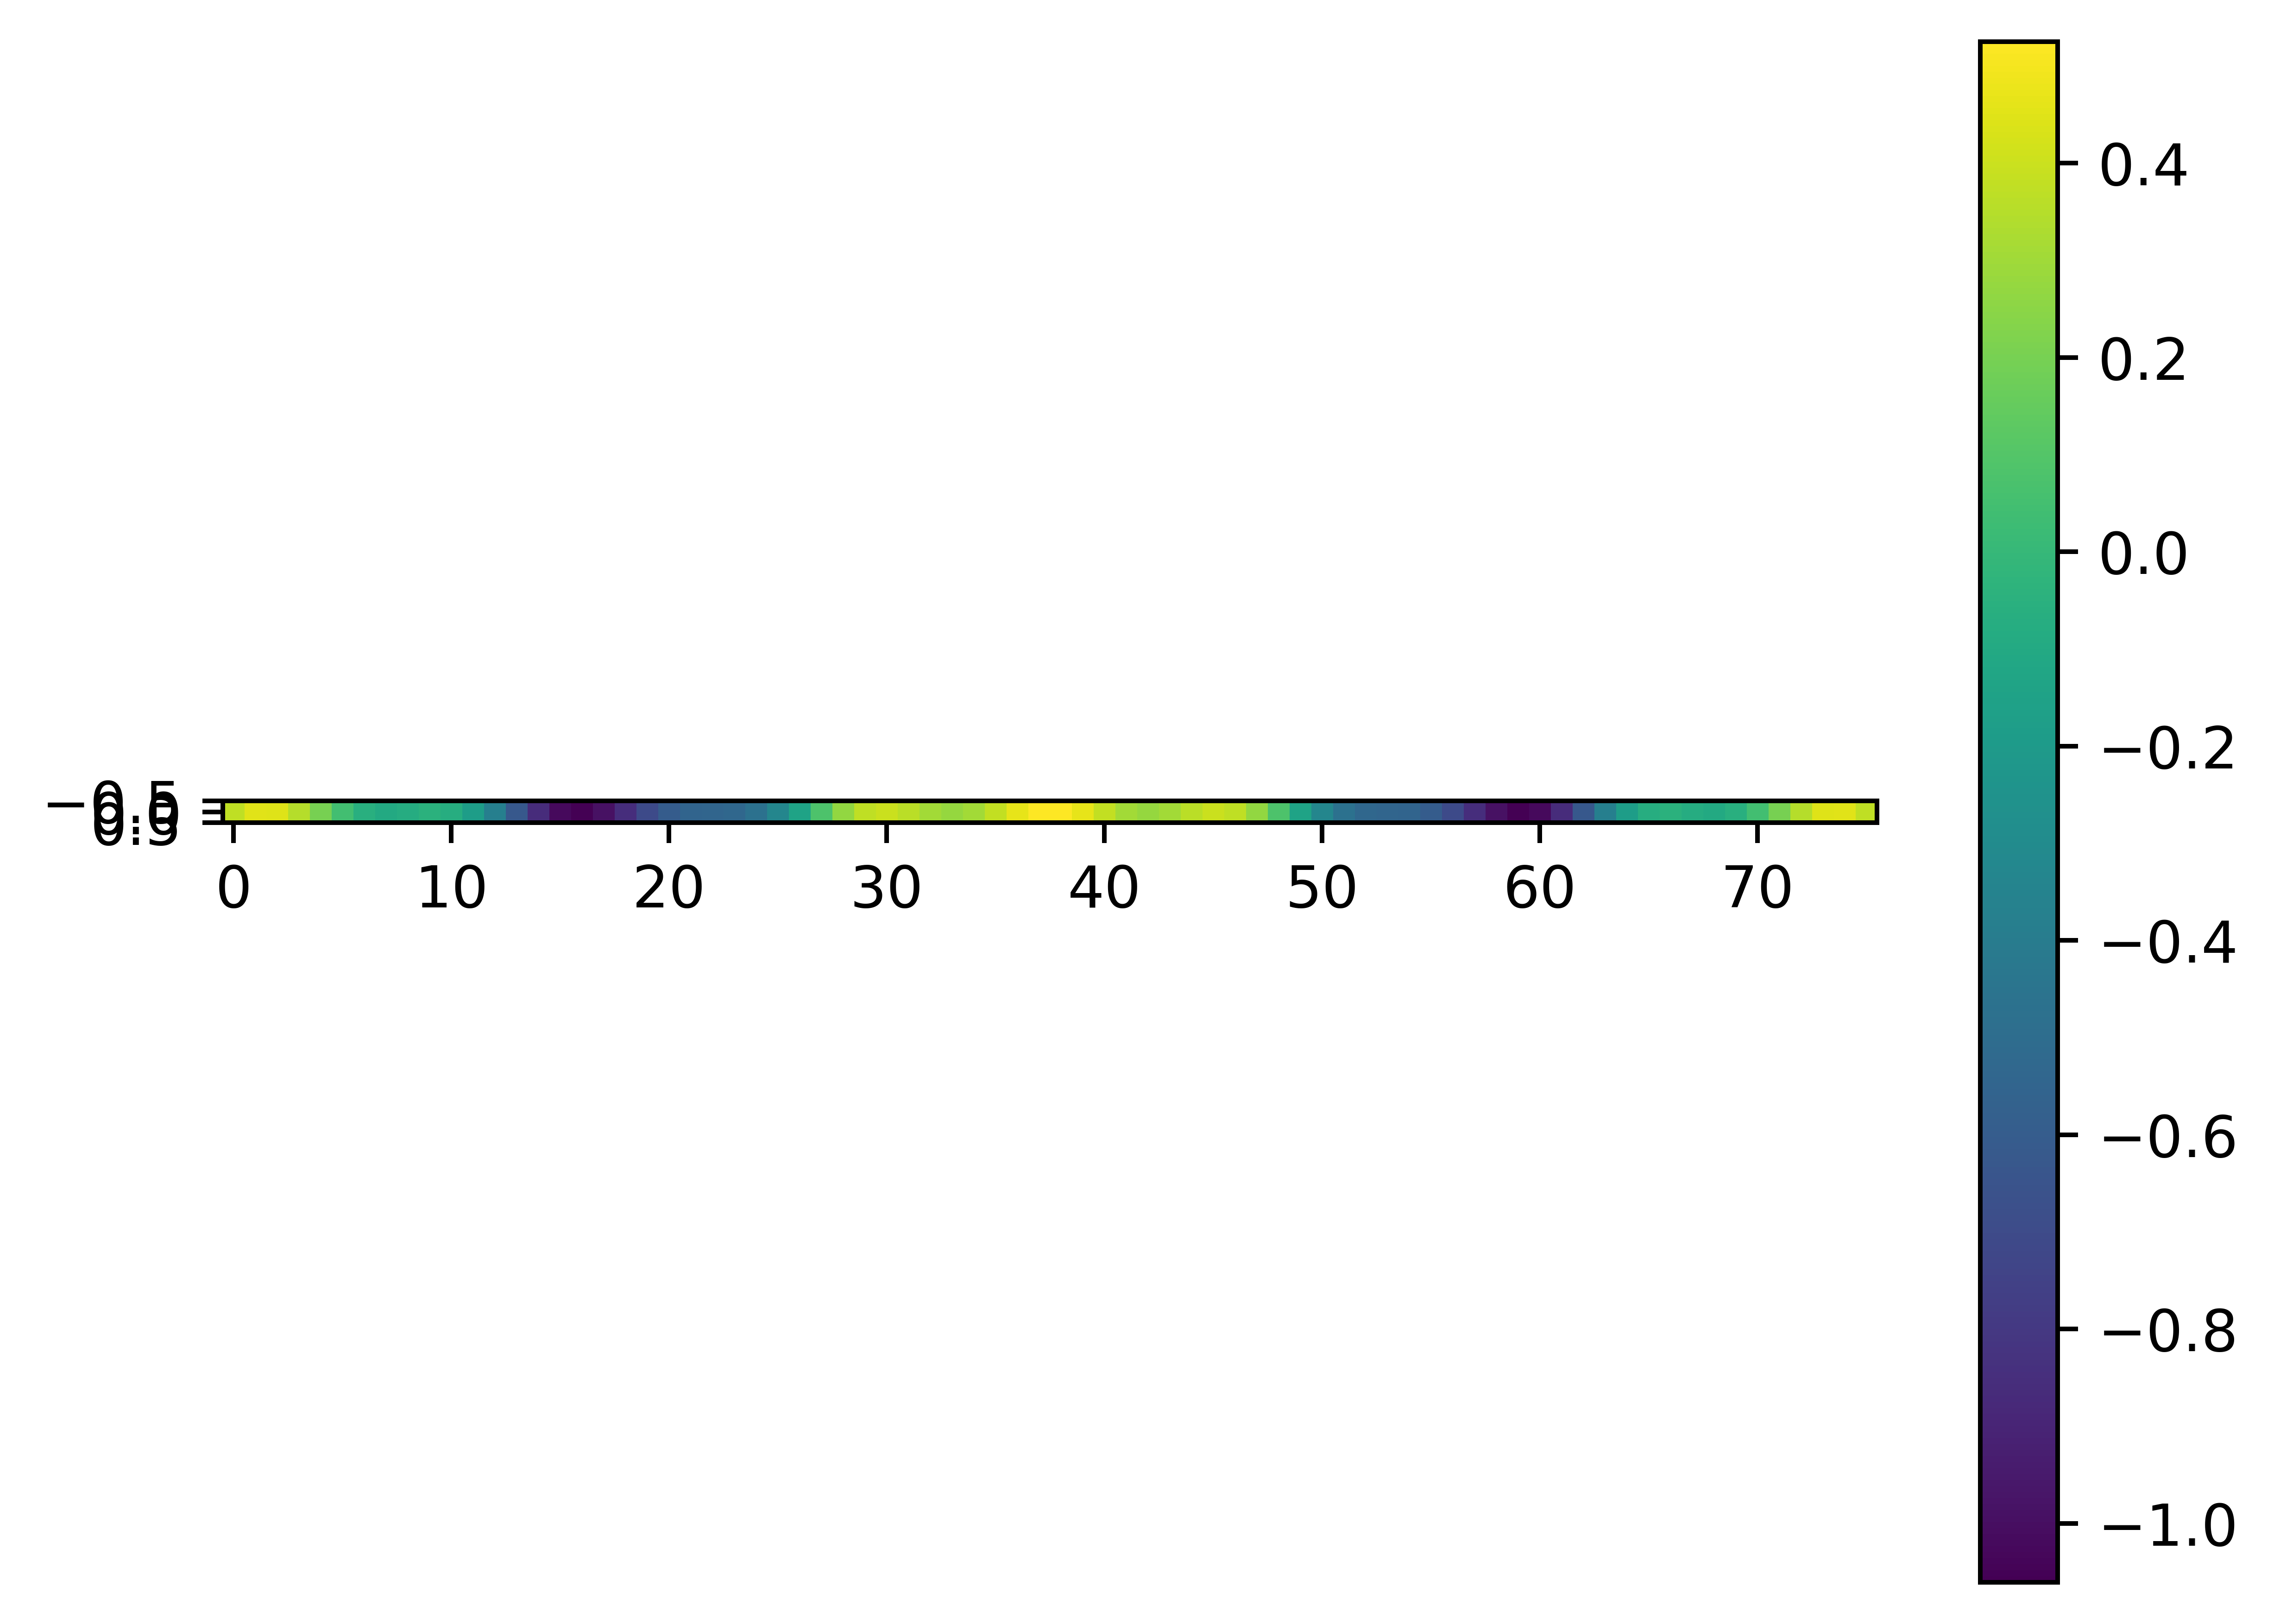

In [94]:
plt.figure(dpi=900)
dJ_du_0 = dJ_du.reshape(Nx, 1)
plt.imshow(np.rot90(dJ_du_0.reshape(Nx, 1)),)
# plt.ylabel("Adjoint Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))
plt.colorbar()

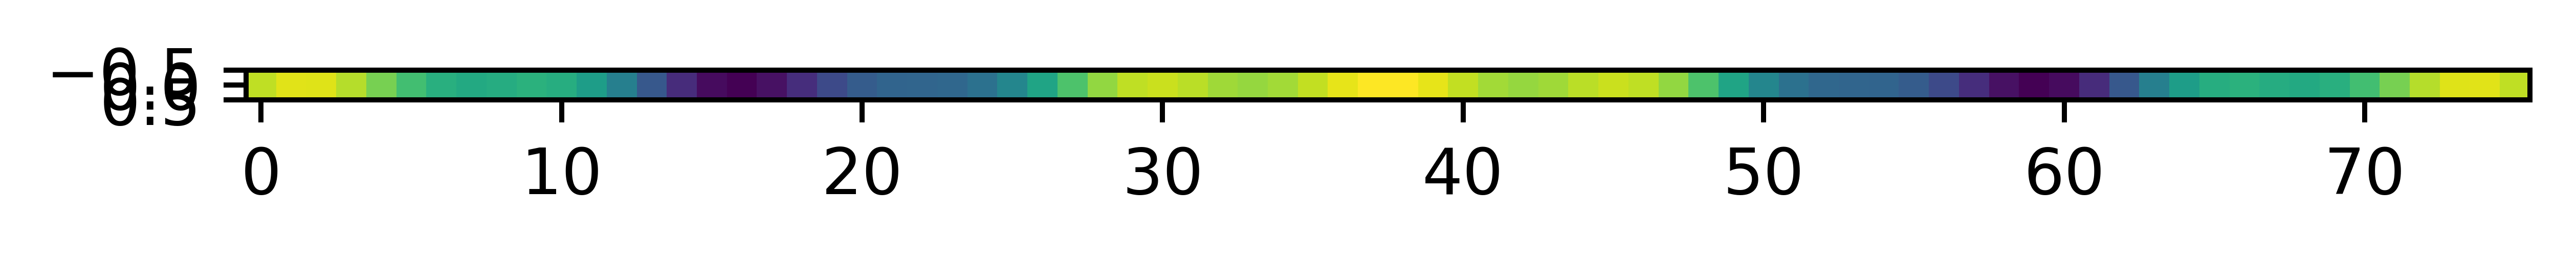

In [95]:
plt.figure(dpi=900)
g_discrete_0 = np.squeeze(g_discrete).reshape(Nx, 1)
plt.imshow(np.rot90(g_discrete_0.reshape(Nx, 1)),)
# plt.ylabel("Finite Difference Gradient")
plt.clim(np.min(dJ_du_0), np.max(dJ_du_0))

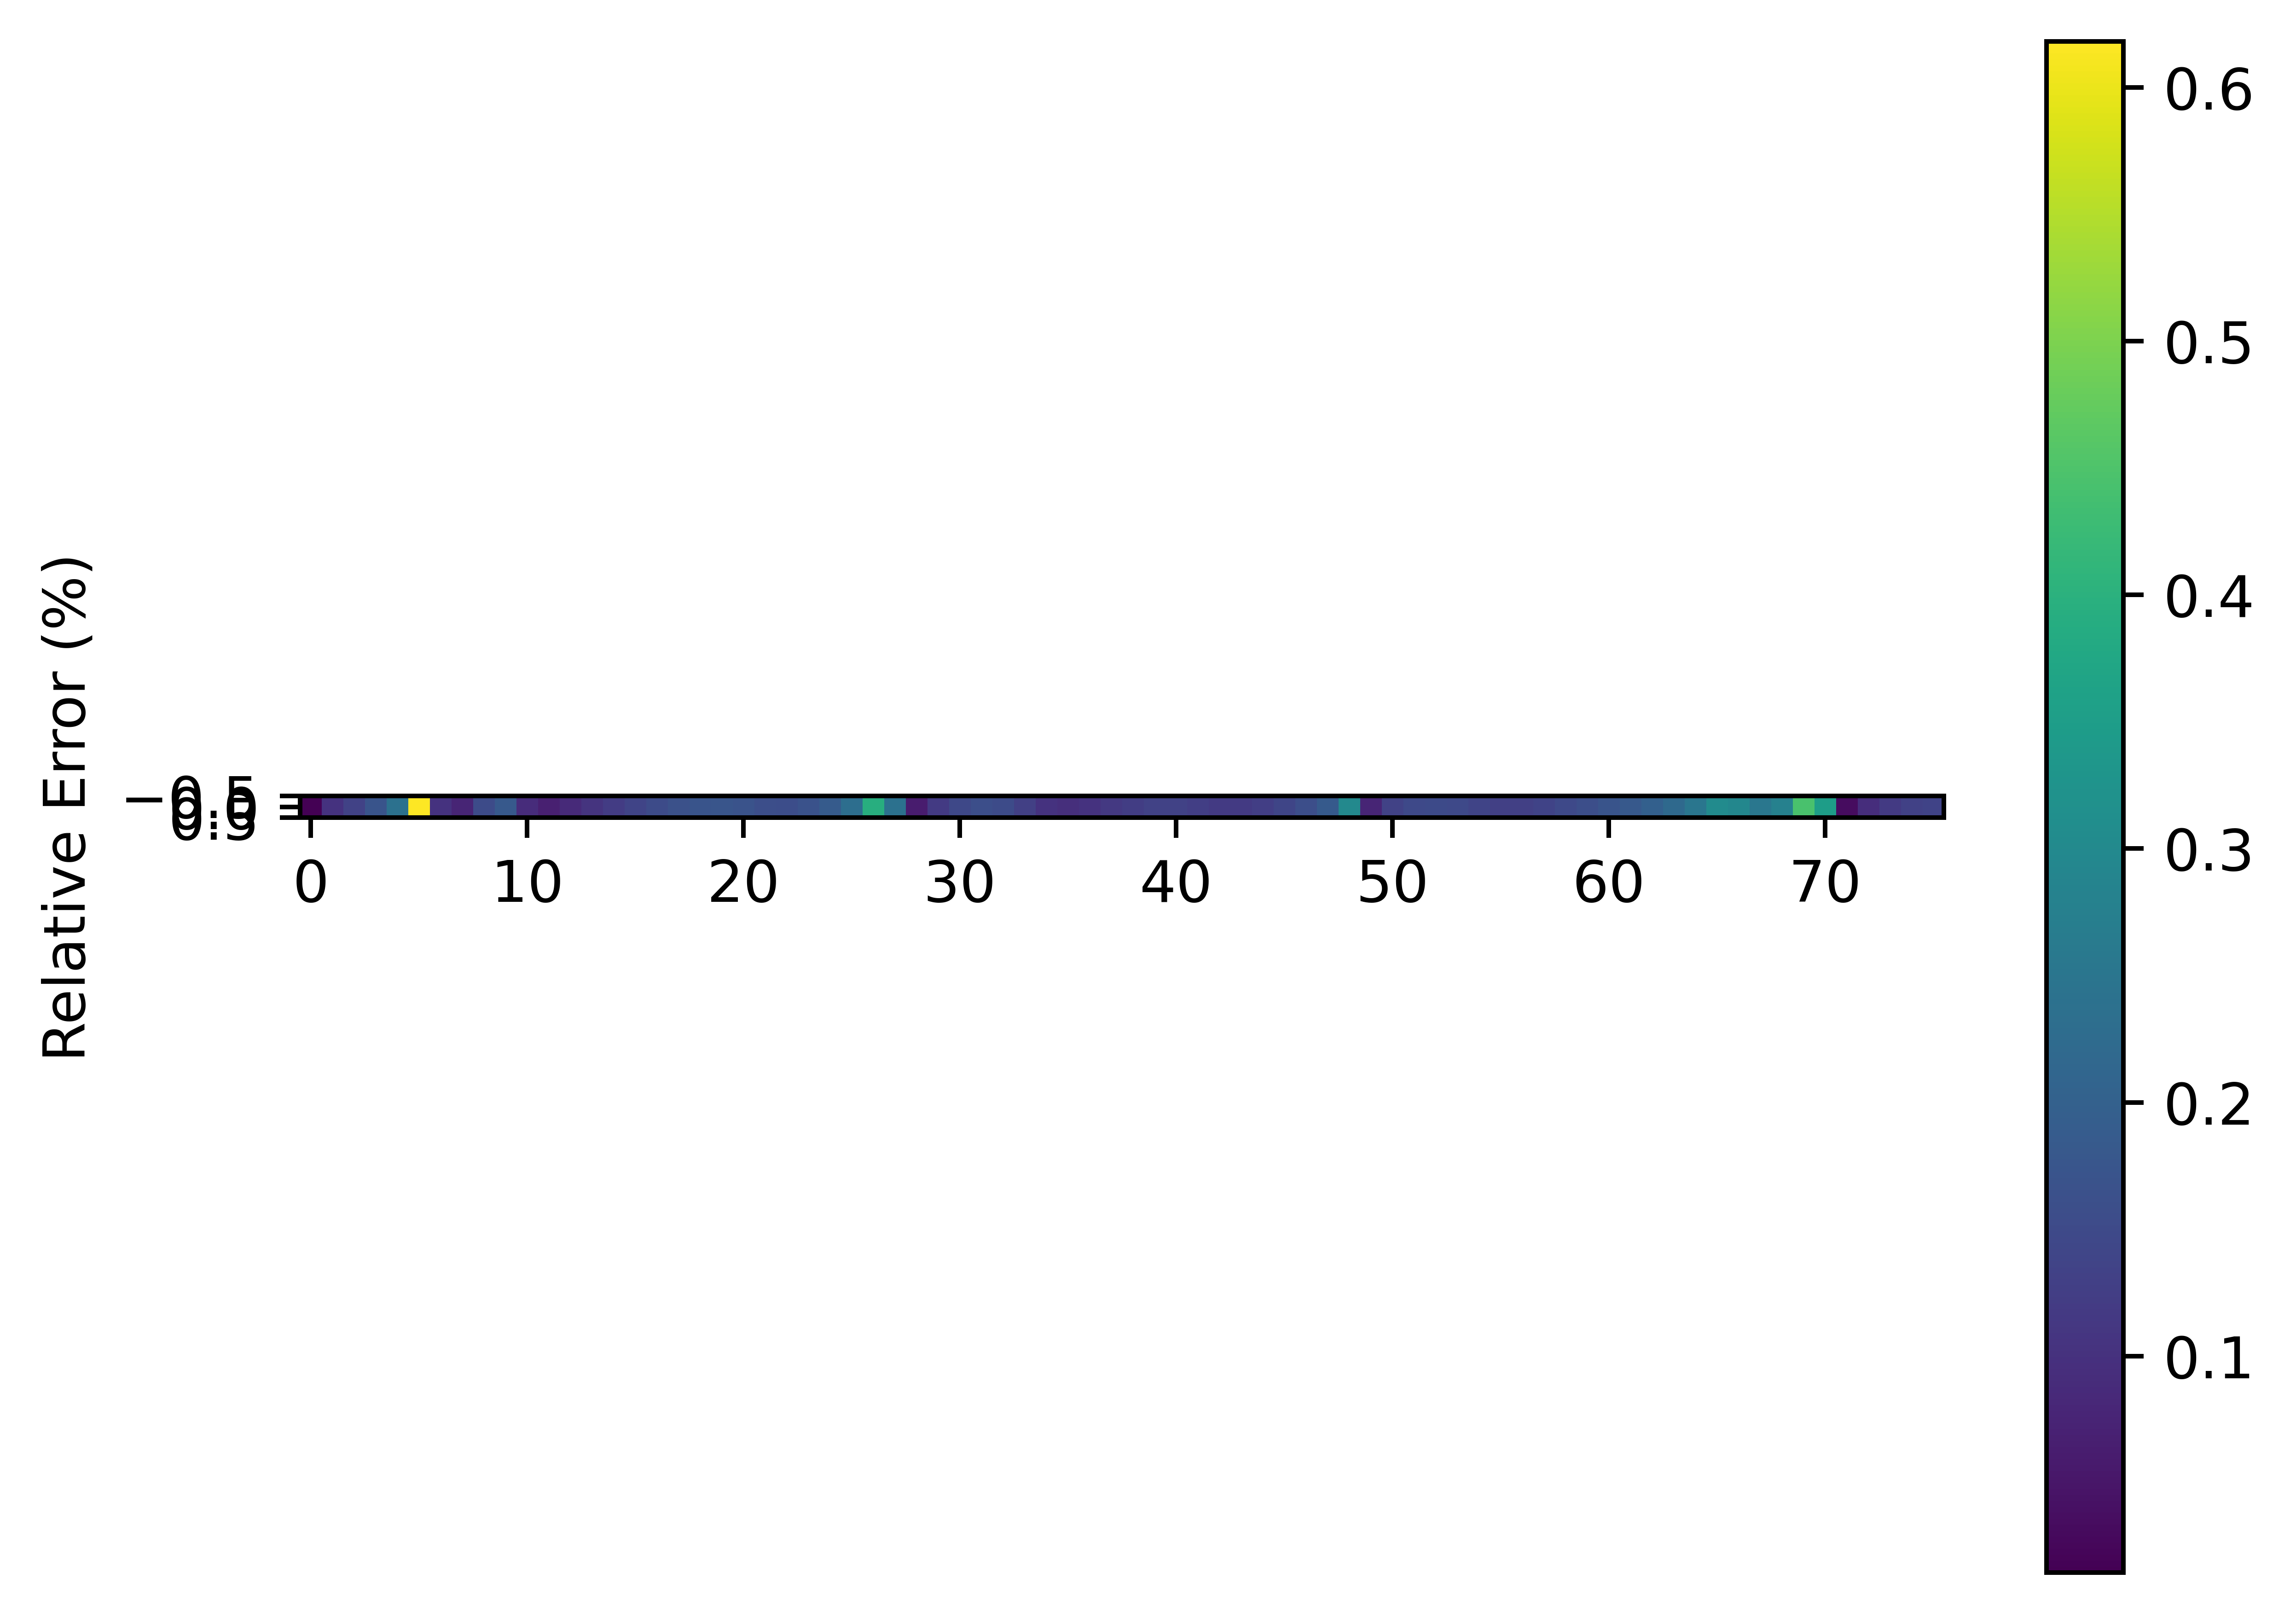

In [96]:
plt.figure(dpi=900)
err_p=rel_err.reshape(Nx, 1)
plt.imshow(np.rot90(err_p.reshape(Nx, 1)),)
plt.ylabel("Relative Error (%)")
plt.colorbar()

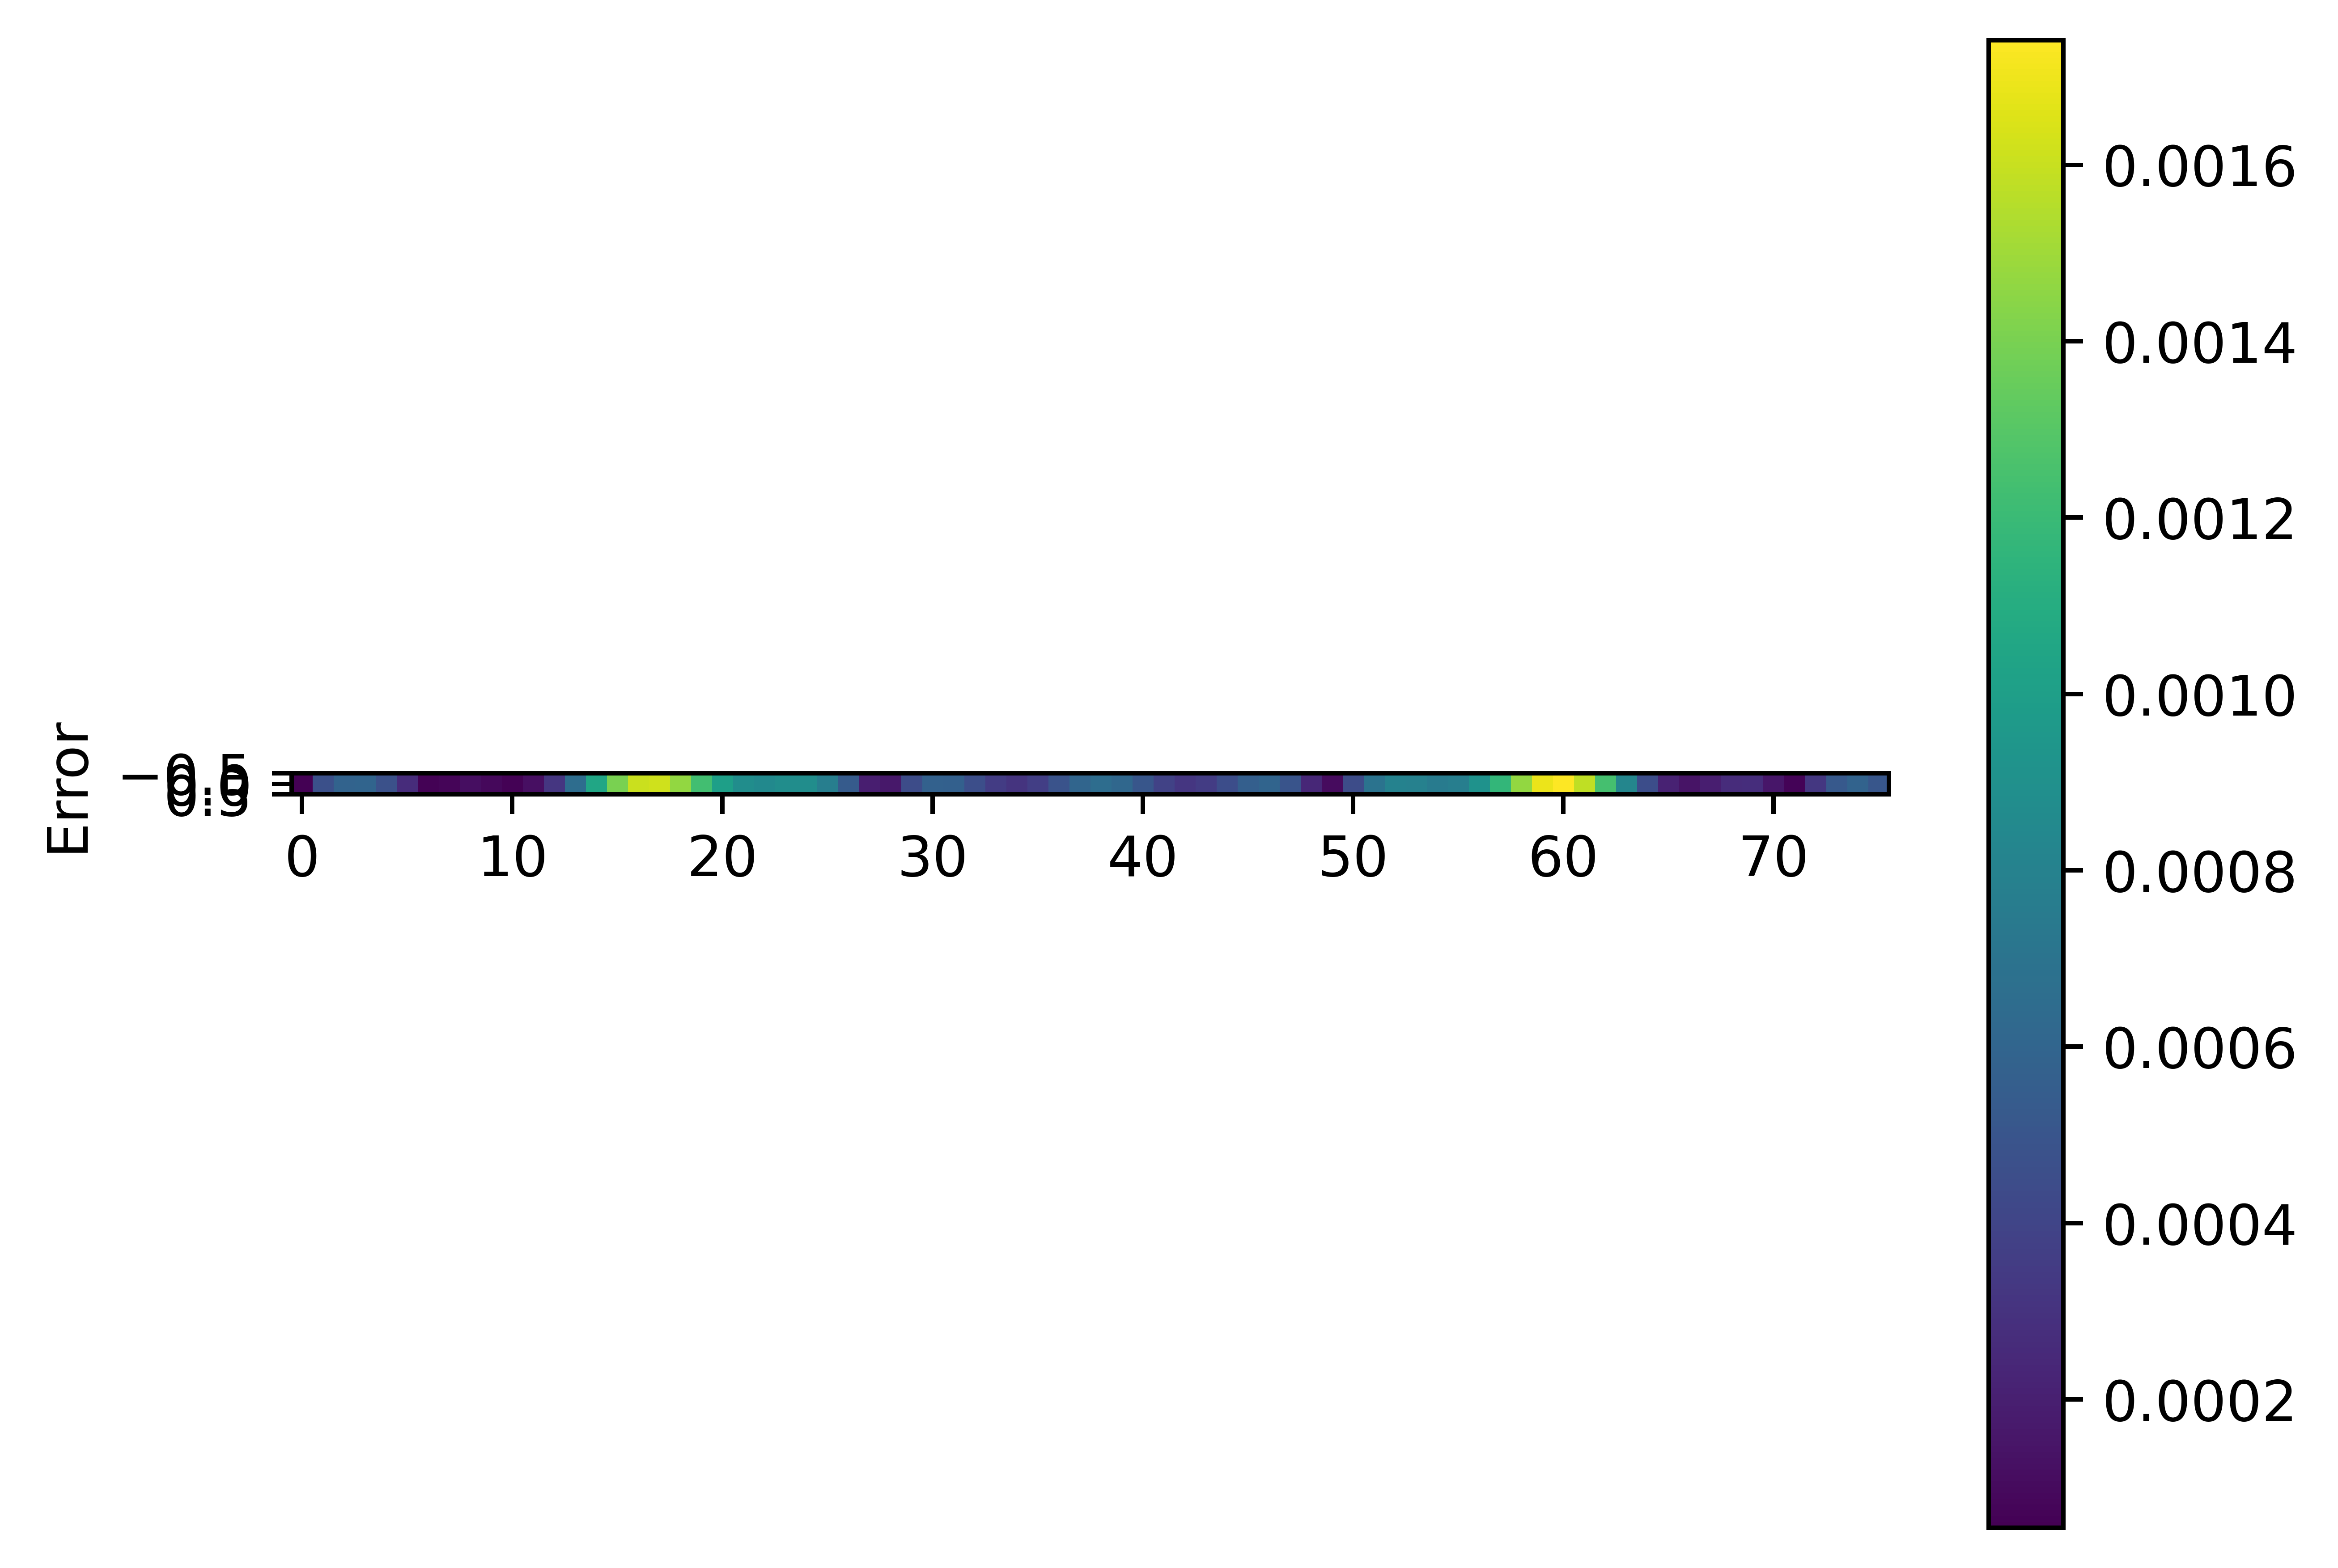

In [97]:
plt.figure(dpi=900)
r_err = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0)))
plt.imshow(np.rot90(r_err.reshape(Nx, 1)),)
plt.ylabel("Error")
plt.colorbar()

In [98]:
gdJ_du = fd_gradient

sdJ_du = g_discrete

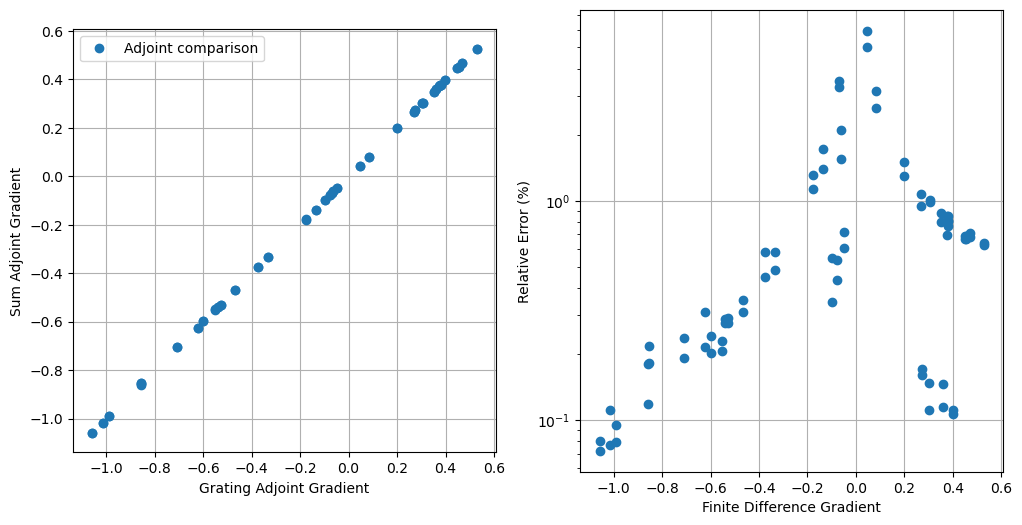

In [99]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(gdJ_du, sdJ_du, "o", label="Adjoint comparison")
plt.xlabel("Grating Adjoint Gradient")
plt.ylabel("Sum Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(gdJ_du) - np.squeeze(sdJ_du))
    / np.abs(np.squeeze(gdJ_du))
    * 100
)
plt.semilogy(gdJ_du, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")
plt.show()

plt.savefig("graph.png")
plt.cla()   # clear the current axes
plt.clf()   # clear the current figure
plt.close() # closes the current figure
plt.show()